# Reprojection

To improve the signal to noise we can combine multiple images together to increase the ratio of signal to noise. Summing or averaging images will increase the signal linearly with the number of images $N$, but the noise will only increase as $\sqrt{N}$.

We'll begin with a simple problem: combining a set images of the same field and averaging them. You can use the images of Stephan's Quintet from September 22nd to do this. You should reduce and plate solve this night's data before starting.

Before you start stacking, do the following:
1. load and display one of each image in B, V and R filters, 
2. measure the standard deviation of a small patch in the corner of each image that doesn't have much light from a Galaxy. 

Note: I tested this on a different set of images than you will use, so you'll need to change some values.

In [1]:
#Import all the modules we'll need

from astropy import __version__ as apversion
from astropy.nddata import CCDData
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from astropy.visualization import hist,ZScaleInterval,simple_norm
from astropy.stats import histogram
from astropy.coordinates import ICRS
import scipy.stats as sps
import photutils as phot
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import ccdproc as ccdp
import astropy.units as u

from pathlib import Path
import warnings
warnings.simplefilter("ignore")
import os

import sys
sys.path.append('/home/idies/workspace/Storage/fzohrabi/persistent/hrpo-pipeline')
import aperturePhot as ap
import plateSolve

%matplotlib inline
print(apversion)
os.getcwd()

5.0


'/home/idies/workspace/Storage/fzohrabi/persistent/ASTR7361'

We'll be using the reproject python module. If you need to install it, you can do so in a terminal using:
`mamba install -c astropy reproject`

You can find the package documentation [here](https://reproject.readthedocs.io/en/stable/#).

We'll be using the `reproject_interp` and `reproject_exact` methods.

In [2]:
from reproject import reproject_interp,reproject_exact

In [3]:
#Change this for your data directory
base = "/home/idies/workspace/"
data_dir = "Temporary/fzohrabi/scratch/20221128/reduced/"
path = os.path.join(base, data_dir)

os.chdir(path)
#if os.path.exists("reduced") == False:
#    os.mkdir("reduced")
images = ccdp.ImageFileCollection(path, glob_include= '*.wcs.fit')

Now that we have reduced data, let's measure some statistics of the background in the images of each color. In particular, we can measure the standard deviation of part of the image that shows blank sky.

In [4]:
import glob
directory = "/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/"    #Folder containing science images
files=glob.glob(directory + '*.wcs.fit')
print(len(files))
print(files)


13
['/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN2022sfc_002R.wcs.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN2022sfc_004R.wcs.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN2022xzm_1128_stackV.wcs.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN2022sfc_006R.wcs.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN2022xzm-003V.wcs.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN2022vqz-001R.wcs.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN2022xzm-001V.wcs.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN2022vqz-001V.wcs.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN2022xzm-002R.wcs.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN2022vqz-002V.wcs.fit', '/home/idies/workspace/Temporary/fzohrabi/scratch/20221128/reduced/SN

OK, now we're ready to reproject the images. This is code is a little bit more complicated than it needs to be thanks to 1. ccdproc's combiner requiring CCDData as input, and 2. CCDData not liking our WCS header information. So, you need to load the images as HDULists using fits.open(), reproject the data, then convert it into a CCDData object to pass to combiner.

1
2
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  DATE-OBS= '2022-11-29T00:18:01' / YYYY-MM-DDThh:mm:ss observation start, UT     EXPTIME =                  60. / Exposure time in seconds                       EXPOSURE=                  60. / Exposure time in seconds                       SET-TEMP=                 -20. / CCD temperature setpoint in C                  CCD-TEMP=         -20.32739775 / CCD temperature at start of exposure in C      XPIXSZ  =                  13. / Pixel Width in microns (after binning)         YPIXSZ  =                  13. / Pixel Height in microns (after binning)        XBINNING=                    1 / Bin

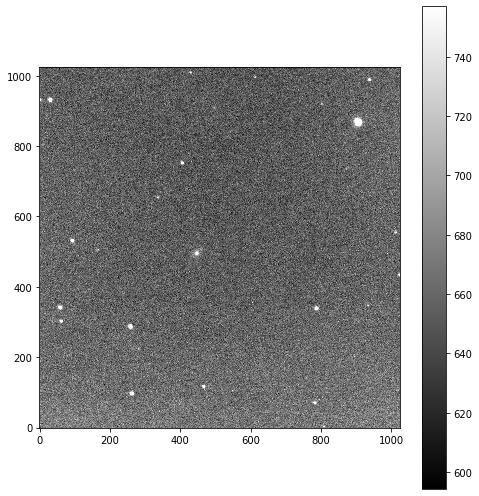

In [13]:
#Define some dictionaries
stack = {} 
array = {}
footprint = {}
ccds = {}

reprojected = [] #List of the reprojected images

for i in range(1,3):
    print (i)
    ccds[i] = fits.open(path+'SN2022xzm-00%dV.wcs.fit' %i)

reproj_to_hdr = ccds[1][0].header  
print (ccds[2][0].header)
for i in ccds:
    print(i)
    tmpimage, footprint[i] = reproject_exact(ccds[i][0], reproj_to_hdr)
    
    tmpccd = CCDData(tmpimage.data,unit=u.adu)
    print(tmpccd)
    ap.showimage(tmpccd)
    reprojected.append(tmpccd)


combiner = ccdp.Combiner(reprojected)
combiner.sigma_clipping(low_thresh=3, high_thresh=3,func=np.ma.median)
stackR = combiner.average_combine()

ap.showimage(stackR)

hdustack=fits.ImageHDU(data=stackR,header=reproj_to_hdr)
hdustack.writeto(directory + 'SN2022xzm_1128_stack%s.wcs.fit' % ("V"),overwrite=True)



In [ ]:

stack = {} 
array = {}
footprint = {}
ccds = {}

reprojected = [] #List of the reprojected images
stringfilt= 'V'
for i in range(1,3):
    print (i)
    ccds[i] = fits.open(path/('SN2022xzm-00%dR.wcs.fit' % (i))

reproj_to_hdr = ccds[1][0].header


for i in ccds:
    print(i)
    tmpimage, footprint[i] = reproject_interp(ccds[i][0], reproj_to_hdr)
    tmpccd = CCDData(tmpimage.data,unit=u.adu)
    ap.showimage(tmpccd) #if you want to see what's happening
    reprojected.append(tmpccd)

combiner = ccdp.Combiner(reprojected)
combiner.sigma_clipping(low_thresh=3, high_thresh=3,func=np.ma.median)
stack[filt] = combiner.average_combine()

ap.showimage(stack[filt])
hdustack=fits.ImageHDU(data=stack[filt],header=reproj_to_hdr)
hdustack.writeto(directory + 'SN2022xzm_stack%s.fit' % ("R"),overwrite=True)

You'll need to rerun the above cell for each filter or wrap a loop around the code.

Once you've run the above cell on each filter, measure the standard deviation of the same corner of each stack that you produced. What's changed?

In [ ]:
#Recompute standard deviation, but for the stacked image. How does it compare to 
#your prediction?


Next, download the stacked images you created, plus one of each raw image in each filter. Use DS9 to create two color images: one using the single input images, the second using the stacked images. What do you notice? Save each color image with the `File->Export` command and send them to me in slack.